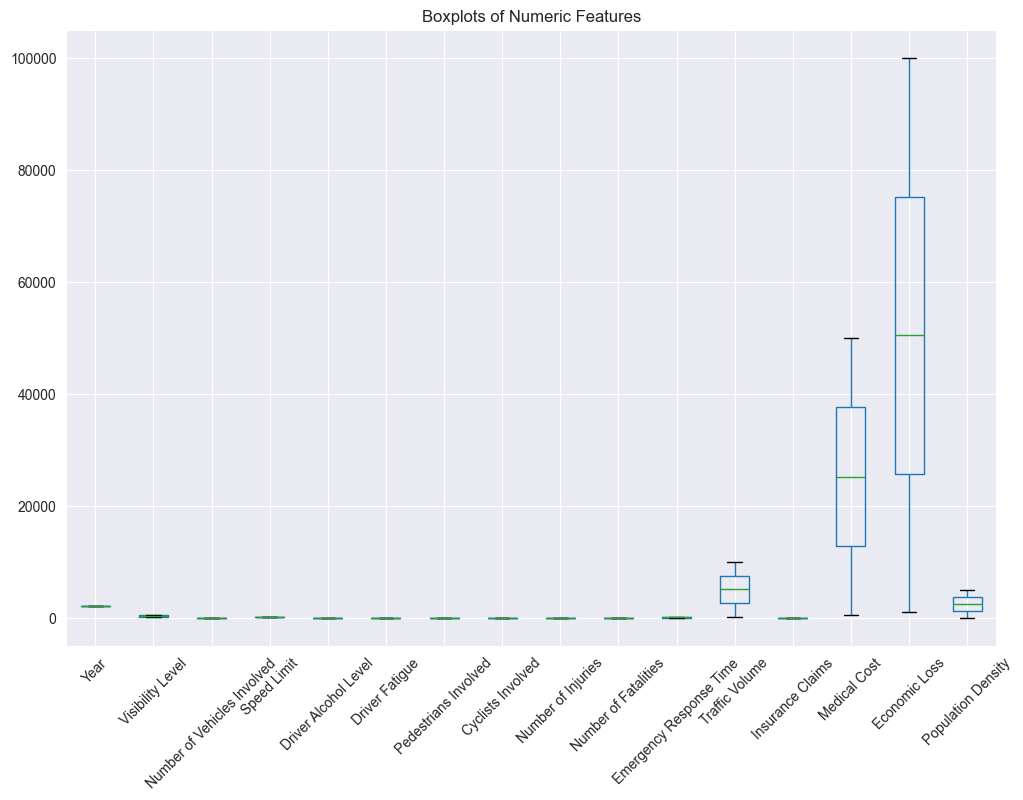

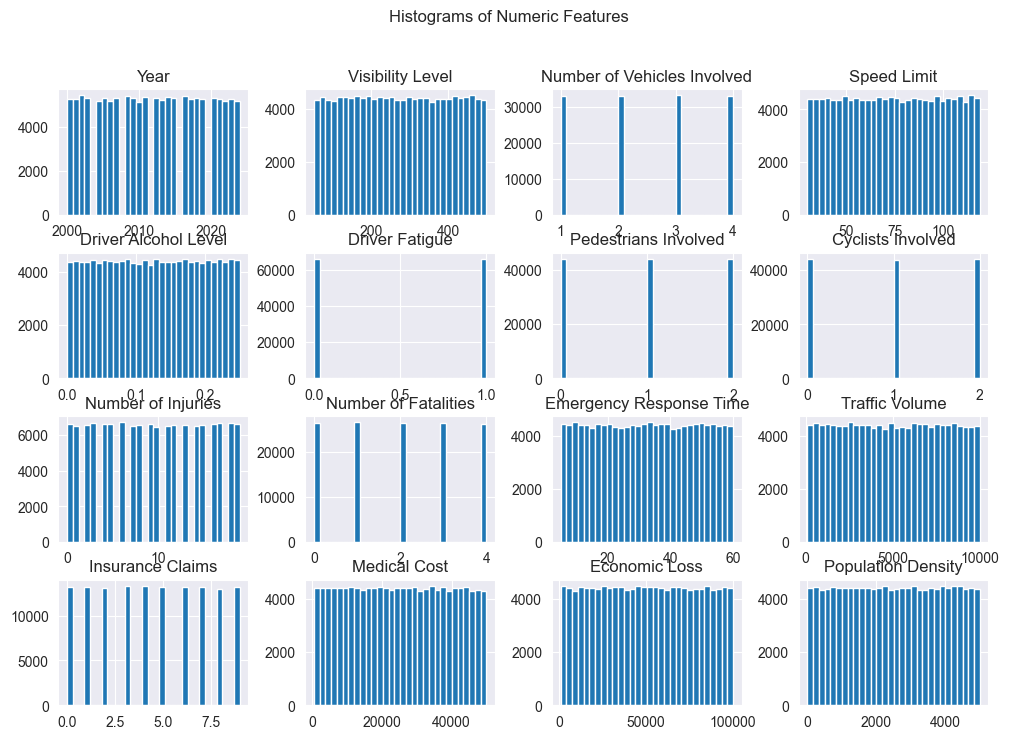

Test MSE - BGD: 827642108.2649782, SGD: 910620323.9591988, MBGD: 810741223.7451532


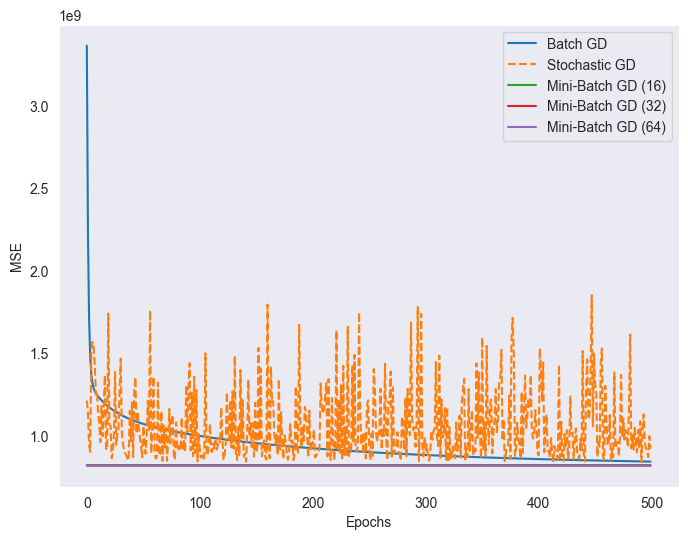

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("darkgrid")

# Load Dataset
file_path = "dataset.csv"
data = pd.read_csv(file_path)

# Display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.colheader_justify", "left")

# Clean Data
# Drop missing values
data = data.dropna()

# Select Numeric Columns
numeric_cols = data.select_dtypes(include=['number']).columns

# Boxplots
plt.figure(figsize=(12, 8))
data[numeric_cols].boxplot(rot=45)
plt.title("Boxplots of Numeric Features")
plt.show()

# Histograms
data[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Histograms of Numeric Features")
plt.show()

# Feature Selection
selected_cols = [
    'Economic Loss', 'Medical Cost', 'Visibility Level', 'Insurance Claims', 'Traffic Volume',
    'Driver Age Group', 'Accident Cause', 'Vehicle Condition',
    'Month', 'Urban/Rural', 'Country'
]

data_selected = data[selected_cols].copy()

# One-Hot Encoding & Label Encoding
ohe_categorical_columns = ['Country', 'Month', 'Urban/Rural', 'Accident Cause']
le_categorical_columns = ['Driver Age Group', 'Vehicle Condition']

# Label Encoding
driver_age_mapping = {"<18": 0, "18-25": 1, "26-40": 2, "41-60": 3, "61+": 4}
vehicle_condition_mapping = {"Poor": 0, "Moderate": 1, "Good": 2}

data_selected["Driver Age Group"] = data_selected["Driver Age Group"].map(driver_age_mapping)
data_selected["Vehicle Condition"] = data_selected["Vehicle Condition"].map(vehicle_condition_mapping)

data_selected = pd.get_dummies(data_selected, columns=ohe_categorical_columns)

# Normalization
numerical_columns = ['Visibility Level', 'Traffic Volume', 'Medical Cost']
mean_values = data_selected[numerical_columns].mean()
std_values = data_selected[numerical_columns].std()
data_selected[numerical_columns] = (data_selected[numerical_columns] - mean_values) / std_values

# Define X(features) and y(target variable)
X = data_selected.drop(columns=['Economic Loss']).values
y = data_selected['Economic Loss'].values.reshape(-1, 1)

# Add bias term (intercept) to X
X = np.c_[np.ones((X.shape[0], 1)), X]

# Train-Test-Validation Split
train_ratio, val_ratio = 0.7, 0.15
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
split_train = int(train_ratio * X.shape[0])
split_val = split_train + int(val_ratio * X.shape[0])

X_train, X_val, X_test = X[indices[:split_train]], X[indices[split_train:split_val]], X[indices[split_val:]]
y_train, y_val, y_test = y[indices[:split_train]], y[indices[split_train:split_val]], y[indices[split_val:]]

# Initialize Parameters
learning_rate = 0.01
epochs = 500
m = len(y_train)
theta = np.random.randn(X_train.shape[1], 1)

# Training: Batch Gradient Descent
loss_history_bgd = []
theta_bgd = np.copy(theta)
for epoch in range(epochs):
    y_pred = np.dot(X_train, theta_bgd)
    error = y_pred - y_train
    gradients = (1 / m) * np.dot(X_train.T, error)
    theta_bgd -= learning_rate * gradients.astype(np.float64)
    mse = np.mean(error ** 2)
    loss_history_bgd.append(mse)

# Training: Stochastic Gradient Descent
loss_history_sgd = []
theta_sgd = np.copy(theta)
for epoch in range(epochs):
    for i in range(m):
        rand_index = np.random.randint(m)
        X_sample = X_train[rand_index].reshape(1, -1)
        y_sample = y_train[rand_index].reshape(-1, 1)
        y_pred = np.dot(X_sample, theta_sgd)
        error = y_pred - y_sample
        gradients = X_sample.T @ error
        theta_sgd -= learning_rate * gradients.astype(np.float64)
    mse = np.mean((np.dot(X_train, theta_sgd) - y_train) ** 2)
    loss_history_sgd.append(mse)

# Training: Mini-Batch Gradient Descent
batch_sizes = [16, 32, 64]
loss_histories = {}
for batch_size in batch_sizes:
    theta_mbgd = np.copy(theta)
    loss_history = []
    for epoch in range(epochs):
        for i in range(0, m, batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            y_pred = np.dot(X_batch, theta_mbgd)
            error = y_pred - y_batch
            gradients = (1 / batch_size) * np.dot(X_batch.T, error)
            theta_mbgd -= learning_rate * gradients.astype(np.float64)
        mse = np.mean((np.dot(X_train, theta_mbgd) - y_train) ** 2)
        loss_history.append(mse)
    loss_histories[batch_size] = loss_history

# Test Evaluation
y_pred_test_bgd = np.dot(X_test, theta_bgd)
mse_test_bgd = np.mean((y_pred_test_bgd - y_test) ** 2)

y_pred_test_sgd = np.dot(X_test, theta_sgd)
mse_test_sgd = np.mean((y_pred_test_sgd - y_test) ** 2)

y_pred_test_mbgd = np.dot(X_test, theta_mbgd)
mse_test_mbgd = np.mean((y_pred_test_mbgd - y_test) ** 2)

# Final Results
print(f"Test MSE - BGD: {mse_test_bgd}, SGD: {mse_test_sgd}, MBGD: {mse_test_mbgd}")

# Plot Loss Curves
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), loss_history_bgd, label="Batch GD")
plt.plot(range(epochs), loss_history_sgd, label="Stochastic GD", linestyle='dashed')
for batch_size, loss_history in loss_histories.items():
    plt.plot(range(epochs), loss_history, label=f"Mini-Batch GD ({batch_size})")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()
